<a href="https://colab.research.google.com/github/HowardHNguyen/Data_Science_for_Healthcare/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's verify the models are trained correctly and interpret the results more closely. Here's what you can do to ensure the models are working as expected:

1. Verify the Training Process:
Ensure that the models have been trained properly and that the training data is representative.

2. Check Feature Importance:
Review the feature importances to understand which features the model is prioritizing.

3. Cross-Validate the Models:
Use cross-validation to ensure the models are not overfitting or underfitting.

4. Review Probability Calibration:
Ensure the probabilities are calibrated correctly. Sometimes, models can be miscalibrated and not reflect true probabilities accurately.

## Step-by-Step Verification
**1. Verify the Training Process:**

First, ensure that you have handled the NaN values correctly and that the models have been trained with a representative dataset.

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

# Load dataset from GitHub
data_url = 'https://github.com/HowardHNguyen/cvd/raw/master/frmgham2.csv'
data = pd.read_csv(data_url)

# Handle missing or infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Define features and target variable
X = data[['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE', 'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS', 'STROKE', 'HYPERTEN']]
y = data['CVD']

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting Machine model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Save the trained models to .pkl files
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(gbm_model, 'gbm_model.pkl')

# Evaluate models on test set
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
gbm_accuracy = accuracy_score(y_test, gbm_model.predict(X_test))
gbm_roc_auc = roc_auc_score(y_test, gbm_model.predict_proba(X_test)[:, 1])

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest ROC AUC: {rf_roc_auc}")
print(f"Gradient Boosting Machine Accuracy: {gbm_accuracy}")
print(f"Gradient Boosting Machine ROC AUC: {gbm_roc_auc}")


Random Forest Accuracy: 0.8400687876182287
Random Forest ROC AUC: 0.7839592257686491
Gradient Boosting Machine Accuracy: 0.8413585554600171
Gradient Boosting Machine ROC AUC: 0.8075219925094819


**2. Check Feature Importance:**

Review the feature importances to ensure that the model is using the correct features.

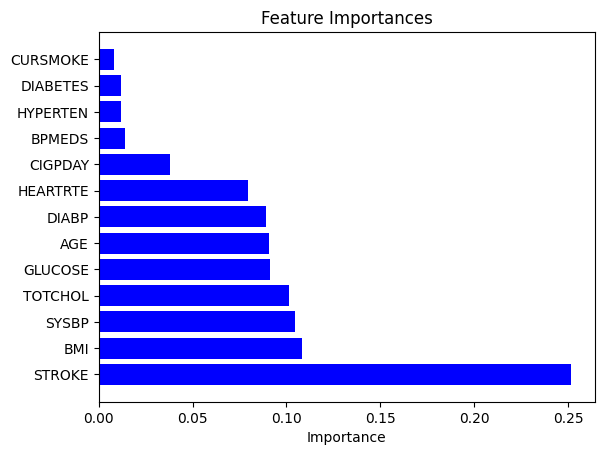

In [4]:
import matplotlib.pyplot as plt

# Feature importances for Random Forest
rf_importances = rf_model.feature_importances_
feature_names = ['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE', 'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS', 'STROKE', 'HYPERTEN']
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots()
ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
ax.set_xlabel('Importance')
ax.set_title('Feature Importances')
plt.show()

**3. Cross-Validate the Models:**

Use cross-validation to ensure the models are not overfitting or underfitting.

In [5]:
from sklearn.model_selection import cross_val_score

rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
gbm_cv_scores = cross_val_score(gbm_model, X, y, cv=5, scoring='roc_auc')

print(f"Random Forest CV ROC AUC: {rf_cv_scores.mean()} (+/- {rf_cv_scores.std() * 2})")
print(f"Gradient Boosting Machine CV ROC AUC: {gbm_cv_scores.mean()} (+/- {gbm_cv_scores.std() * 2})")

Random Forest CV ROC AUC: 0.7766324142723569 (+/- 0.02315951463575755)
Gradient Boosting Machine CV ROC AUC: 0.7939482981074264 (+/- 0.03056142004477584)


**4. Review Probability Calibration:**

Ensure the probabilities are calibrated correctly.

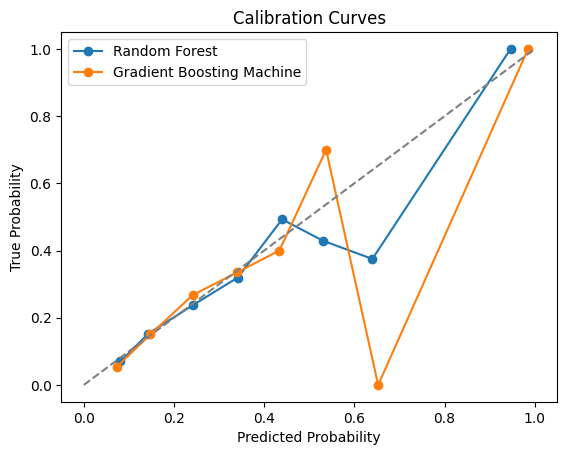

In [6]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

rf_model_calibrated = CalibratedClassifierCV(rf_model, method='sigmoid')
rf_model_calibrated.fit(X_train, y_train)

gbm_model_calibrated = CalibratedClassifierCV(gbm_model, method='sigmoid')
gbm_model_calibrated.fit(X_train, y_train)

# Save calibrated models
joblib.dump(rf_model_calibrated, 'rf_model_calibrated.pkl')
joblib.dump(gbm_model_calibrated, 'gbm_model_calibrated.pkl')

# Calibration curves
prob_true_rf, prob_pred_rf = calibration_curve(y_test, rf_model_calibrated.predict_proba(X_test)[:, 1], n_bins=10)
prob_true_gbm, prob_pred_gbm = calibration_curve(y_test, gbm_model_calibrated.predict_proba(X_test)[:, 1], n_bins=10)

fig, ax = plt.subplots()
ax.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest')
ax.plot(prob_pred_gbm, prob_true_gbm, marker='o', label='Gradient Boosting Machine')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('True Probability')
ax.set_title('Calibration Curves')
ax.legend()
plt.show()

**Streamlit App Code**

Code for Streamlit app and save as app.py, we will implement these above calibrated models saved as rf_model_calibrated.pkl and gbm_model_calibrated.pkl:

In [ ]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score
import os
import urllib.request

# Function to download the file
def download_file(url, dest):
    try:
        urllib.request.urlretrieve(url, dest)
        return True
    except Exception as e:
        st.error(f"Error downloading {url}: {e}")
        return False

# URLs for the model files
rf_model_url = 'https://raw.githubusercontent.com/HowardHNguyen/cvd/master/rf_model_calibrated.pkl'
gbm_model_url = 'https://raw.githubusercontent.com/HowardHNguyen/cvd/master/gbm_model_calibrated.pkl'

# Local paths for the model files
rf_model_path = 'rf_model_calibrated.pkl'
gbm_model_path = 'gbm_model_calibrated.pkl'

# Download the models if not already present
if not os.path.exists(rf_model_path):
    st.info(f"Downloading {rf_model_path}...")
    download_file(rf_model_url, rf_model_path)

if not os.path.exists(gbm_model_path):
    st.info(f"Downloading {gbm_model_path}...")
    download_file(gbm_model_url, gbm_model_path)

# Load the calibrated models
try:
    rf_model_calibrated = joblib.load(rf_model_path)
    gbm_model_calibrated = joblib.load(gbm_model_path)
except Exception as e:
    st.error(f"Error loading models: {e}")

# Load the dataset
data_url = 'https://raw.githubusercontent.com/HowardHNguyen/cvd/master/frmgham2.csv'
try:
    data = pd.read_csv(data_url)
except Exception as e:
    st.error(f"Error loading data: {e}")

# Handle missing values by replacing them with the mean of the respective columns
if 'data' in locals():
    data.fillna(data.mean(), inplace=True)

# Define the feature columns
feature_columns = ['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE',
                   'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS',
                   'STROKE', 'HYPERTEN']

# Sidebar for input parameters
st.sidebar.header('Enter your parameters')

def user_input_features():
    age = st.sidebar.slider('Enter your age:', 32, 81, 54)
    totchol = st.sidebar.slider('Total Cholesterol:', 107, 696, 200)
    sysbp = st.sidebar.slider('Systolic Blood Pressure:', 83, 295, 151)
    diabp = st.sidebar.slider('Diastolic Blood Pressure:', 30, 150, 89)
    bmi = st.sidebar.slider('BMI:', 14.43, 56.80, 26.77)
    cursmoke = st.sidebar.selectbox('Current Smoker:', (0, 1))
    glucose = st.sidebar.slider('Glucose:', 39, 478, 117)
    diabetes = st.sidebar.selectbox('Diabetes:', (0, 1))
    heartrate = st.sidebar.slider('Heart Rate:', 37, 220, 91)
    cigpday = st.sidebar.slider('Cigarettes Per Day:', 0, 90, 20)
    bpmeds = st.sidebar.selectbox('On BP Meds:', (0, 1))
    stroke = st.sidebar.selectbox('Stroke:', (0, 1))
    hyperten = st.sidebar.selectbox('Hypertension:', (0, 1))

    data = {
        'AGE': age,
        'TOTCHOL': totchol,
        'SYSBP': sysbp,
        'DIABP': diabp,
        'BMI': bmi,
        'CURSMOKE': cursmoke,
        'GLUCOSE': glucose,
        'DIABETES': diabetes,
        'HEARTRTE': heartrate,
        'CIGPDAY': cigpday,
        'BPMEDS': bpmeds,
        'STROKE': stroke,
        'HYPERTEN': hyperten
    }
    features = pd.DataFrame(data, index=[0])
    return features

input_df = user_input_features()

# Apply the model to make predictions
if st.sidebar.button('Predict'):
    try:
        rf_proba_calibrated = rf_model_calibrated.predict_proba(input_df)[:, 1]
        gbm_proba_calibrated = gbm_model_calibrated.predict_proba(input_df)[:, 1]
    except Exception as e:
        st.error(f"Error making predictions: {e}")

    st.write("""
    # CVD Prediction App by Howard Nguyen
    This app predicts the probability of cardiovascular disease (CVD) using user inputs.
    """)

    st.subheader('Predictions')
    try:
        st.write(f"- Random Forest model: Your CVD with probability prediction is {rf_proba_calibrated[0]:.2f}")
        st.write(f"- Gradient Boosting Machine model: Your CVD with probability prediction is {gbm_proba_calibrated[0]:.2f}")
    except:
        pass

    # Plot the prediction probability distribution
    st.subheader('Prediction Probability Distribution')
    try:
        fig, ax = plt.subplots()
        bars = ax.bar(['Random Forest', 'Gradient Boosting Machine'], [rf_proba_calibrated[0], gbm_proba_calibrated[0]], color=['blue', 'orange'])
        ax.set_ylim(0, 1)
        ax.set_ylabel('Probability')
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # va: vertical alignment
        st.pyplot(fig)
    except:
        pass

    # Plot feature importances for Random Forest
    st.subheader('Feature Importances (Random Forest)')
    try:
        rf_base_model = rf_model_calibrated.estimator  # Access the base estimator
        fig, ax = plt.subplots()
        importances = rf_base_model.feature_importances_
        indices = np.argsort(importances)
        ax.barh(range(len(indices)), importances[indices], color='blue', align='center')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([feature_columns[i] for i in indices])
        ax.set_xlabel('Importance')
        st.pyplot(fig)
    except Exception as e:
        st.error(f"Error plotting feature importances: {e}")

    # Plot ROC curve for both models
    st.subheader('Model Performance')
    try:
        fig, ax = plt.subplots()
        fpr_rf, tpr_rf, _ = roc_curve(data['CVD'], rf_model_calibrated.predict_proba(data[feature_columns])[:, 1])
        fpr_gbm, tpr_gbm, _ = roc_curve(data['CVD'], gbm_model_calibrated.predict_proba(data[feature_columns])[:, 1])
        ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(data["CVD"], rf_model_calibrated.predict_proba(data[feature_columns])[:, 1]):.2f})')
        ax.plot(fpr_gbm, tpr_gbm, label=f'Gradient Boosting Machine (AUC = {roc_auc_score(data["CVD"], gbm_model_calibrated.predict_proba(data[feature_columns])[:, 1]):.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend(loc='best')
        st.pyplot(fig)
    except Exception as e:
        st.error(f"Error plotting ROC curve: {e}")
else:
    st.write("## Cardiovascular Disease Prediction App")
    st.write("### Enter your parameters and click Predict to get the results.")


## OLD code to backup Re-Generate the top two models

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import joblib

# Load dataset from GitHub
data_url = 'https://github.com/HowardHNguyen/cvd/raw/master/frmgham2.csv'
data = pd.read_csv(data_url)

# Handle missing or infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Define features and target variable
X = data[['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE', 'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS', 'STROKE', 'HYPERTEN']]
y = data['CVD']

# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting Machine model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Save the trained models to .pkl files
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(gbm_model, 'gbm_model.pkl')

# Print the accuracy of the models on the test set
print(f"Random Forest Accuracy: {rf_model.score(X_test, y_test)}")
print(f"Gradient Boosting Machine Accuracy: {gbm_model.score(X_test, y_test)}")


Random Forest Accuracy: 0.8400687876182287
Gradient Boosting Machine Accuracy: 0.8413585554600171


### Backup Streamlit App
Ensure the Streamlit app loads the newly trained models:

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import requests
import io
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Load models from local files
rf_model = joblib.load('rf_model.pkl')
gbm_model = joblib.load('gbm_model.pkl')

# Load dataset from GitHub
data_url = 'https://github.com/HowardHNguyen/cvd/raw/master/frmgham2.csv'
data = pd.read_csv(data_url)

# Handle missing or infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Split the dataset for training and validation
X = data[['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE', 'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS', 'STROKE', 'HYPERTEN']]
y = data['CVD']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the Streamlit app layout
st.title("Cardiovascular Disease Prediction")
st.write("Select normal values for * marked fields if you don't know the exact values")

# Input features in the left column
col1, col2 = st.columns([1, 2], gap="large")

with col1:
    age = st.slider('Enter your age:', min_value=32, max_value=81, value=54)
    tot_chol = st.slider('Total Cholesterol:', min_value=107, max_value=696, value=200)
    sysbp = st.slider('Systolic Blood Pressure:', min_value=83, max_value=295, value=151)
    diabp = st.slider('Diastolic Blood Pressure:', min_value=30, max_value=150, value=89)
    bmi = st.slider('BMI:', min_value=14.43, max_value=56.80, value=26.77)
    cur_smoker = st.selectbox('Current Smoker:', [0, 1])
    glucose = st.slider('Glucose:', min_value=39, max_value=478, value=117)
    diabetes = st.selectbox('Diabetes:', [0, 1])
    heartrate = st.slider('Heart Rate:', min_value=37, max_value=220, value=91)
    cigs_per_day = st.slider('Cigarettes Per Day:', min_value=0, max_value=90, value=20)
    bp_meds = st.selectbox('On BP Meds:', [0, 1])
    prev_strk = st.selectbox('Stroke:', [0, 1])
    hypertension = st.selectbox('Hypertension:', [0, 1])

# Collect input features
features = [age, tot_chol, sysbp, diabp, bmi, cur_smoker, glucose, diabetes, heartrate, cigs_per_day, bp_meds, prev_strk, hypertension]
input_data = np.array(features).reshape(1, -1)

# Predict and display results in the right column
with col2:
    if st.button('Predict'):
        # Make predictions
        rf_proba = rf_model.predict_proba(input_data)[0][1]  # Probability of CVD for Random Forest
        gbm_proba = gbm_model.predict_proba(input_data)[0][1]  # Probability of CVD for Gradient Boosting Machine

        # Display predictions
        st.write(f"Random Forest Prediction: CVD with probability {rf_proba:.2f}")
        st.write(f"Gradient Boosting Machine Prediction: CVD with probability {gbm_proba:.2f}")

        # Plot Prediction Probability Distribution
        fig, ax = plt.subplots()
        ax.bar(['Random Forest', 'Gradient Boosting Machine'], [rf_proba, gbm_proba], color=['blue', 'orange'])
        ax.set_ylim(0, 1)
        ax.set_ylabel('Probability')
        ax.set_title('Prediction Probability Distribution')
        st.pyplot(fig)

        # Feature importances for Random Forest
        st.subheader("Feature Importances (Random Forest)")
        rf_importances = rf_model.feature_importances_
        feature_names = ['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE', 'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS', 'STROKE', 'HYPERTEN']
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        fig, ax = plt.subplots()
        ax.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
        ax.set_xlabel('Importance')
        ax.set_title('Feature Importances')
        st.pyplot(fig)

        # ROC Curve and AUC
        st.subheader("Model Performance")

        # Generate ROC curve data from the validation set
        rf_probas_val = rf_model.predict_proba(X_val)[:, 1]
        gbm_probas_val = gbm_model.predict_proba(X_val)[:, 1]

        fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_probas_val)
        fpr_gbm, tpr_gbm, _ = roc_curve(y_val, gbm_probas_val)

        fig, ax = plt.subplots()
        ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_val, rf_probas_val):.2f})')
        ax.plot(fpr_gbm, tpr_gbm, label=f'Gradient Boosting Machine (AUC = {roc_auc_score(y_val, gbm_probas_val):.2f})')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curve')
        ax.legend()
        st.pyplot(fig)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Load models
rf_model = joblib.load('rf_model.pkl')
gbm_model = joblib.load('gbm_model.pkl')

# Load data
data = pd.read_csv('/content/drive/MyDrive/data/frmgham2.csv')

# Split data into features and labels
X = data[['AGE', 'TOTCHOL', 'SYSBP', 'DIABP', 'BMI', 'CURSMOKE',
          'GLUCOSE', 'DIABETES', 'HEARTRTE', 'CIGPDAY', 'BPMEDS', 'STROKE', 'HYPERTEN']]
y = data['CVD']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure there are no NaN or infinite values in the validation data
X_val = X_val.replace([np.inf, -np.inf], np.nan).dropna()
y_val = y_val.loc[X_val.index]

# Define the app layout
st.title('Cardiovascular Disease Prediction by Howard Nguyen')
st.write('Select normal values for * marked fields if you don\'t know the exact values')

col1, col_space, col2 = st.columns([1, 0.1, 1])

with col1:
    # User inputs with sliders
	age = st.slider('Enter your age:', min_value=32, max_value=81, value=32)
	totchol = st.slider('Total Cholesterol:', min_value=107, max_value=696, value=200)
	sysbp = st.slider('Systolic Blood Pressure:', min_value=83, max_value=295, value=120)
	diabp = st.slider('Diastolic Blood Pressure:', min_value=30, max_value=150, value=80)
	bmi = st.slider('BMI:', min_value=14.43, max_value=56.8, value=25.0)
	cursmoke = st.selectbox('Current Smoker:', [0, 1])
	glucose = st.slider('Glucose:', min_value=39, max_value=478, value=100)
	diabetes = st.selectbox('Diabetes:', [0, 1])
	heartrate = st.slider('Heart Rate:', min_value=37, max_value=220, value=70)
	cigpday = st.slider('Cigarettes Per Day:', min_value=0, max_value=90, value=0)
	bpmeds = st.selectbox('On BP Meds:', [0, 1])
	stroke = st.selectbox('Stroke:', [0, 1])
	hyperten = st.selectbox('Hypertension:', [0, 1])

predict_button = col2.button('Predict Your CVD Probability')

if predict_button:
    input_data = pd.DataFrame({
        'AGE': [age], 'TOTCHOL': [totchol], 'SYSBP': [sysbp], 'DIABP': [diabp],
        'BMI': [bmi], 'CURSMOKE': [cursmoke], 'GLUCOSE': [glucose], 'DIABETES': [diabetes],
        'HEARTRTE': [heartrate], 'CIGPDAY': [cigpday], 'BPMEDS': [bpmeds],
        'STROKE': [stroke], 'HYPERTEN': [hyperten]
    })

    # Make predictions
    rf_proba = rf_model.predict_proba(input_data)
    gbm_proba = gbm_model.predict_proba(input_data)
    rf_pred = rf_model.predict(input_data)[0]
    gbm_pred = gbm_model.predict(input_data)[0]

    with col2:
        # Show predictions
        st.write(f"Random Forest Prediction: {'CVD' if rf_pred else 'No CVD'} with probability {rf_proba[0][1]:.2f}")
        st.write(f"Gradient Boosting Machine Prediction: {'CVD' if gbm_pred else 'No CVD'} with probability {gbm_proba[0][1]:.2f}")

        st.subheader("Prediction Probability Distribution")
        plt.figure(figsize=(10, 5))
        plt.hist(rf_proba[:, 1], bins=10, alpha=0.5, label='Random Forest')
        plt.hist(gbm_proba[:, 1], bins=10, alpha=0.5, label='Gradient Boosting Machine')
        plt.xlabel('Probability')
        plt.ylabel('Frequency')
        plt.title('Prediction Probability Distribution')
        plt.legend()
        st.pyplot(plt)

        st.subheader("Feature Importances (Random Forest)")
        feature_importances = rf_model.feature_importances_
        features = X.columns
        plt.figure(figsize=(10, 5))
        plt.barh(features, feature_importances, color='royalblue')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        st.pyplot(plt)

        # Static ROC Curve Calculation using validation data
        fpr_rf, tpr_rf, _ = roc_curve(y_val, rf_model.predict_proba(X_val)[:, 1])
        fpr_gbm, tpr_gbm, _ = roc_curve(y_val, gbm_model.predict_proba(X_val)[:, 1])

        st.subheader("Model Performance")
        plt.figure(figsize=(10, 5))
        plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_val, rf_model.predict_proba(X_val)[:, 1]):.2f})')
        plt.plot(fpr_gbm, tpr_gbm, label=f'Gradient Boosting Machine (AUC = {roc_auc_score(y_val, gbm_model.predict_proba(X_val)[:, 1]):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        st.pyplot(plt)
